In [208]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
import pymoc
from pymoc.util.catalog import catalog_to_moc
from pymoc.io.fits import read_moc_fits
from scipy.stats import norm,kstest
import xidplus

from astropy.table import Table,vstack,Column,join,hstack
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky,search_around_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc

In [206]:
def find_posteror_source(source_num,source_id,instrument):
    #finds the pkl file corresponding to the source you give.
    # Source_num: the row number of the source you want the pkl file for
    # Source_id: the sources id
    # Instrument: either MIPS, PACS or SPIRE to denote which instrument you want the pkl file for
    
    if instrument!=('MIPS' and 'PACS' and 'SPIRE'):
        print('ERROR instrument is not MIPS, PACS or SPIRE')
        return()
    
    if type(source_num)==int:
        source_num = [source_num]
        source_id = [source_id]
    

    source_list = []
    for n,num in enumerate(source_num):
        file_num = int(num/10)
        #print(file_num)
        print('data/fir/{}/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl.pkl'.format(instrument,file_num,file_num))
        #name = file_list[file_num].replace('fits','pkl.pkl')
        name = 'data/fir/{}/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl.pkl'.format(instrument,file_num,file_num)
        #print(name)
        priors,posterior = xidplus.load(name)
        #print(source_id[n])
        if source_id[n] not in priors[0].ID:
            print('source number :{}: not in opened file. Something is wrong'.format(num))
        source_list.append([priors,posterior])
        
    return(source_list)

In [2]:
help_masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist[0]

help_id,field,ra,dec,hp_idx,ebv,redshift,zspec,f_wfc_u,ferr_wfc_u,f_ap_wfc_u,ferr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,flag_wfc_u,f_megacam_u,ferr_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,flag_megacam_u,f_suprime_g,ferr_suprime_g,f_ap_suprime_g,ferr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_g,merr_ap_suprime_g,flag_suprime_g,f_megacam_g,ferr_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,flag_megacam_g,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_wfc_g,ferr_wfc_g,f_ap_wfc_g,ferr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,flag_wfc_g,f_suprime_r,ferr_suprime_r,f_ap_suprime_r,ferr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_r,merr_ap_suprime_r,flag_suprime_r,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_wfc_r,ferr_wfc_r,f_ap_wfc_r,ferr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,flag_wfc_r,f_megacam_r,ferr_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,flag_megacam_r,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_suprime_i,ferr_suprime_i,f_ap_suprime_i,ferr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_i,merr_ap_suprime_i,flag_suprime_i,f_wfc_i,ferr_wfc_i,f_ap_wfc_i,ferr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,flag_wfc_i,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_wfc_z,ferr_wfc_z,f_ap_wfc_z,ferr_ap_wfc_z,m_wfc_z,merr_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,flag_wfc_z,f_megacam_z,ferr_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,flag_megacam_z,f_suprime_z,ferr_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_z,merr_ap_suprime_z,flag_suprime_z,f_suprime_n921,ferr_suprime_n921,f_ap_suprime_n921,ferr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n921,merr_ap_suprime_n921,flag_suprime_n921,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_suprime_y,ferr_suprime_y,f_ap_suprime_y,ferr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_y,merr_ap_suprime_y,flag_suprime_y,f_ukidss_j,ferr_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,flag_ukidss_j,f_ukidss_k,ferr_ukidss_k,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,flag_ukidss_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag
,,deg,deg,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [71]:
lofar_sources = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')

In [200]:
lofar_sources[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,flo

In [201]:
lofar_fir = Table.read('data/data_release/XID+_lofar_ELAIS-N1_v0.5.fits')
lofar_fir = join(lofar_sources,lofar_fir,join_type='inner',keys='Source_Name')

In [209]:
find_posteror_source(1,lofar_fir['Source_Name'][1],'SPIRE')

data/fir/SPIRE/xidplus_run_0/lofar_xidplus_fir_0_rerun.pkl.pkl


FileNotFoundError: [Errno 2] No such file or directory: 'data/fir/SPIRE/xidplus_run_0/lofar_xidplus_fir_0_rerun.pkl.pkl'

In [55]:
lofar_data = Table.read('data/data_release/final_component_catalogue-v0.5.fits')
'''spire_moc = pymoc.moc.MOC()
read_moc_fits(spire_moc,'/lustre/scratch/astro/im281/HELP/dmu_products/dmu2/dmu2_field_coverages/ELAIS-N1_MOC.fits')
mask = inMoc(lofar_data['RA'],lofar_data['DEC'],spire_moc)'''
print(len(lofar_data))
lofar_data[0]

85964


Component_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Created,Parent_Source
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes29,bytes22
ILTJ153936.98+580651.7,234.90409574742577,58.11436685178417,0.000910655435717371,0.0010915293854267178,0.03887940165446956,0.014258139852887139,0.002666120985100087,0.0009167623793084566,S,0.008174848212191131,0.004976624331647756,138.96192976652347,0.002918164787813265,0.0016483856941018943,35.943946342848044,0.008003137446445173,0.004686688655986016,138.96192976652344,Ingest components,ILTJ153936.98+580651.7


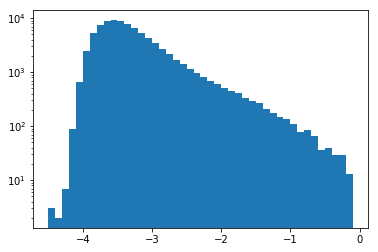

In [27]:
bins = np.arange(-4.5,0,0.1)
y = np.log10(lofar_data['Total_flux'])
plt.hist(y,bins=bins,log=True)
plt.show()

In [46]:
mask = ~np.isnan(help_masterlist['cigale_dustlumin'])
help_ldust = help_masterlist[mask]

ras = lofar_data['RA']
decs = lofar_data['DEC']
lofar_coords = SkyCoord(ras,decs,unit='deg')
moc = catalog_to_moc(lofar_coords,15,12)

moc_mask = inMoc(help_ldust['ra'],help_ldust['dec'],moc)
help_ldust = help_ldust[moc_mask]

In [58]:
c = SkyCoord(help_ldust['ra'],help_ldust['dec'],unit='deg')
spire_moc = pymoc.util.catalog.catalog_to_moc(c,60,15)
mask = inMoc(lofar_data['RA'],lofar_data['DEC'],spire_moc)
lofar_data = lofar_data[mask]
len(lofar_data)

In [60]:
help_coords = SkyCoord(help_ldust['ra'],help_ldust['dec'],unit='deg')
ras = lofar_data['RA']
decs = lofar_data['DEC']
lofar_coords = SkyCoord(ras,decs,unit='deg')

idx_help,d2d,_ = match_coordinates_sky(lofar_coords,help_coords)

In [61]:
joined_lofar_help = hstack([lofar_data,help_ldust[idx_help]])

In [62]:
tmp = np.unique(idx_help)
idx_help_not = [i for i in range(len(help_coords)) if i not in tmp]

dust luminosity is 1312424532557.3186 solar_luminosities at redshift 1.0984
predicted radio flux, using q=2.7 is: 0.42571064135263675mJy
contours are at [-5.64239852e-05 -1.11091849e-06  5.42021483e-05  1.09515215e-04
  1.64828282e-04]
plotting 1 sources
plotting 3 sources


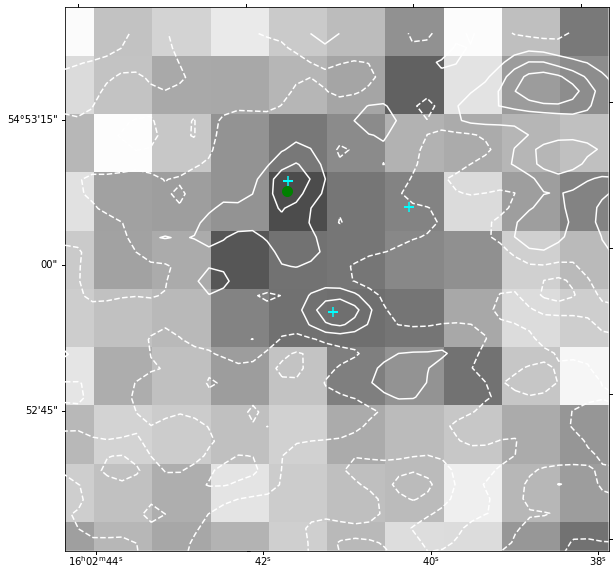

dust luminosity is 1095151167518.55 solar_luminosities at redshift 1.0071
predicted radio flux, using q=2.7 is: 0.4407102944630357mJy
contours are at [-5.90108123e-05 -5.14707466e-06  4.87166630e-05  1.02580401e-04
  1.56444138e-04]
plotting 2 sources
plotting 5 sources


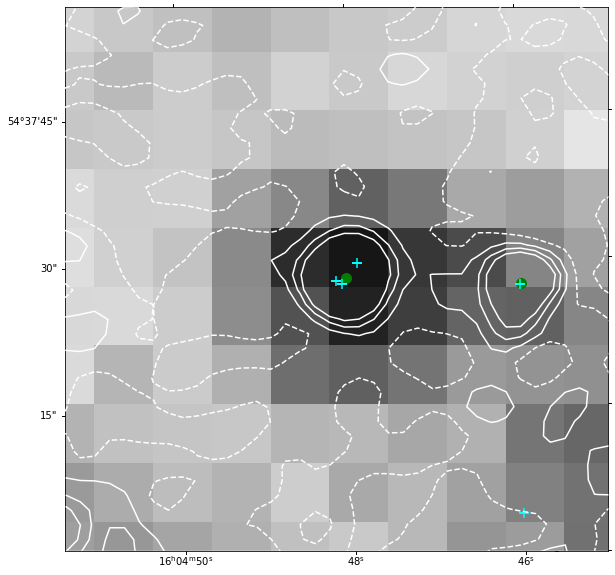

dust luminosity is 1055973289053.5828 solar_luminosities at redshift 1.0658
predicted radio flux, using q=2.7 is: 0.36915734526922556mJy
contours are at [-5.22049382e-05 -2.93655404e-06  4.63318301e-05  9.56002142e-05
  1.44868598e-04]
plotting 1 sources
plotting 3 sources


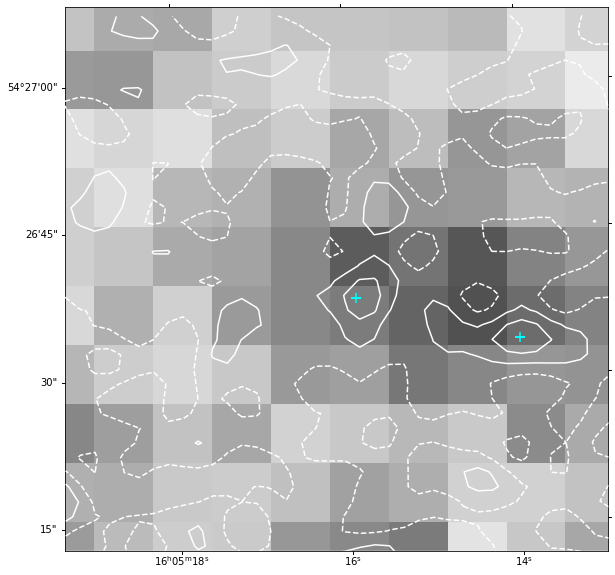

dust luminosity is 1242010266191.896 solar_luminosities at redshift 1.0463
predicted radio flux, using q=2.7 is: 0.4545798433714106mJy
contours are at [-6.05330005e-05 -8.29611945e-06  4.39407616e-05  9.61776427e-05
  1.48414524e-04]
plotting 3 sources
plotting 4 sources


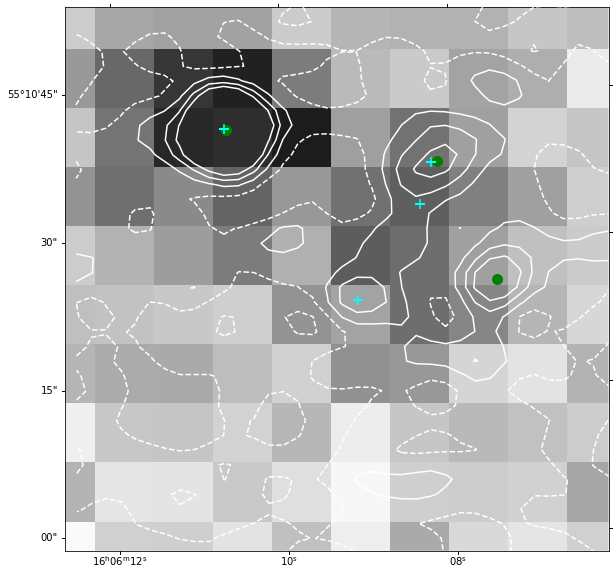

dust luminosity is 1047410162092.201 solar_luminosities at redshift 1.0676
predicted radio flux, using q=2.7 is: 0.36463156749891934mJy
contours are at [-6.09282591e-05 -7.08894944e-06  4.67503602e-05  1.00589670e-04
  1.54428980e-04]
plotting 1 sources
plotting 5 sources


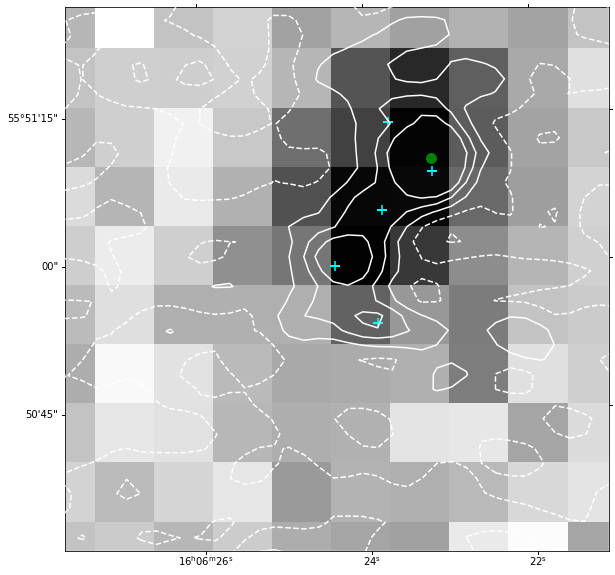

KeyboardInterrupt: 

In [50]:
mask = (np.log10(help_ldust[idx_help_not]['cigale_dustlumin']/3.8E26)>12) & (help_ldust[idx_help_not]['redshift']>1) & (help_ldust[idx_help_not]['redshift']<1.1)
ras = help_ldust[idx_help_not]['ra'][mask]
decs = help_ldust[idx_help_not]['dec'][mask]

imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
hdulist.close()

fname = 'data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}
z = help_ldust[idx_help_not][mask]['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad_pred = 10**(np.log10(help_ldust[idx_help_not][mask]['cigale_dustlumin']/3.75E12) - 1.66)
f_rad_pred = lum_rad_pred/(4*np.pi*dist**2)/1E-29
for n in range(len(ras)):
    print('dust luminosity is {} solar_luminosities at redshift {}'.format(help_ldust[idx_help_not][mask][n]['cigale_dustlumin']/3.8E26,help_ldust[idx_help_not][mask][n]['redshift']))
    print('predicted radio flux, using q=2.7 is: {}mJy'.format(f_rad_pred[n]))
    image_plotting.plot_figure(im250,[lofar_data,help_ldust],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

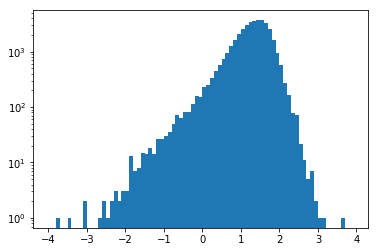

In [63]:
z = joined_lofar_help['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad = (joined_lofar_help['Total_flux']*1E-26/(1+z)**(-0.7))*(4*np.pi*dist**2)
dust_lum = (joined_lofar_help['cigale_dustlumin'])
q = np.log10(dust_lum/3.75E12) - np.log10(lum_rad)
plt.hist(q,log=True,bins=np.arange(-4,4,0.1))
plt.show()

In [ ]:
mask = q<0.0
ras = joined_lofar_help['RA'][mask]
decs = joined_lofar_help['DEC'][mask]

plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

for n in range(len(ras)):

    image_plotting.plot_figure(im250,[lofar_data,help_ldust,lofar_sources],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

In [137]:
idx_help,idx_lofar,d2d,_ = lofar_coords.search_around_sky(help_coords,5/3600*u.degree)

In [138]:
ids,counts = np.unique(idx_lofar,return_counts=True)
mask = counts>1
ids = ids[mask]

In [139]:
len(idx_lofar)

16399

In [ ]:
mask_id = np.array([name in lofar_data['Component_Name'][ids] for name in joined_lofar_help['Component_Name']])
mask_q = q<0.0
mask = mask_id & mask_q
print(np.sum(mask))
ras = joined_lofar_help['RA'][mask]
decs = joined_lofar_help['DEC'][mask]

plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

for n in range(len(ras)):

    image_plotting.plot_figure(im250,[lofar_data,help_ldust,lofar_sources],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

In [140]:
tmp = hstack([lofar_data[idx_lofar],help_ldust[idx_help]])
ids,counts = np.unique(tmp['Component_Name'],return_counts=True)
mask = counts>1
ids = ids[mask]
mask = np.array([name in ids for name in tmp['Component_Name']])
multi_match = tmp[mask]

0
1
3
5
6
7
9
11
12
13
14
16
17
18
19
21
22
24
25
27
28
29
30
32
33
34
35
36
38
39
40
41
42
43
45
46
47
48
49
50
51
52
53
54
55
56
57
59
61
62
63
64
65
66
67
68
69
70
72
74
75
77
78
79
80
81
82
83
84
85
86
87
88
90
92
93
94
95
96
97
98
99
102
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
124
125
126
127
128
130
132
134
136
137
138
139
140
142
143
144
145
146
147
149
151
153
154
155
156
157
158
159
160
162
163
164
165
166
167
169
170
171
172
173
174
175
176
177
178
179
181
182
183
184
186
188
189
190
191
192
193
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
218
219
220
221
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
257
259
260
262
264
265
267
269
270
271
272
273
274
275
276
277
278
280
281
282
283
284
285
286
287
288
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
310
311
313
314
316
317
318
319
320
321
3

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


nan


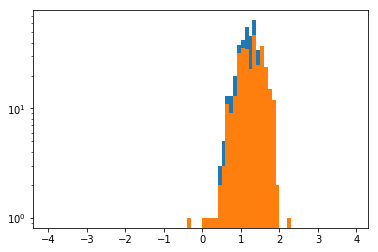

In [195]:
z = multi_match['redshift']
mask = (z>0.8) & (z<1.2)
dist = cosmo.luminosity_distance(z[mask]).to(u.m).value
lum_rad = (multi_match['Total_flux'][mask]*1E-26/(1+z[mask])**(-0.7))*(4*np.pi*dist**2)
dust_lum = (multi_match['cigale_dustlumin'][mask])

flux_rad = []
flux_250 = []
tmp_flux = 0
for n,source in enumerate(multi_match[mask]):
    
    if n==np.sum(mask)-1:
        print('at the end')
        flux_rad.append(multi_match[mask][n]['Total_flux']*1E-26/(1+z[mask][n])**(-0.7)*(4*np.pi*dist[n]**2))
        flux_250.append(tmp_flux)
        continue
        
    if abs(multi_match[mask][n]['redshift']-multi_match[mask][n+1]['redshift'])<0.3:
        tmp_flux = tmp_flux + multi_match[mask][n]['cigale_dustlumin']

    if multi_match[mask][n]['Component_Name']!=multi_match[mask][n+1]['Component_Name']:
        print(n)
        flux_rad.append(multi_match[mask][n]['Total_flux']*1E-26/(1+z[mask][n])**(-0.7)*(4*np.pi*dist[n]**2))
        flux_250.append(tmp_flux)
        tmp_flux = 0
        continue
    






1.2118370221300268
1.2052399120361017
0.015491806842895486
--------
1.2492931236905207
-inf
nan


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


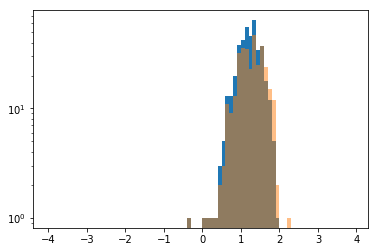

In [197]:
q = np.log10(dust_lum/3.75E12) - np.log10(lum_rad)
plt.hist(q,log=True,bins=np.arange(-4,4,0.1))
print(np.median(q))
print(np.mean(q))
print(np.std(q)/np.sqrt(len(q)))
print('--------')



q = np.log10(np.array(flux_250)/3.75E12) - np.log10(flux_rad)
plt.hist(q,log=True,bins=np.arange(-4,4,0.1),alpha=0.5)
print(np.median(q))
print(np.mean(q))
print(np.std(q)/np.sqrt(len(q)))
plt.show()

In [188]:
q = np.log10(np.array(flux_250)/3.75E12) - np.log10(flux_rad)

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


ValueError: operands could not be broadcast together with shapes (349,) (349,411) 

In [194]:
flux_rad

[<Column name='redshift' dtype='float64' length=411>
  8.706567587580568e+24
 1.1683179775621461e+25
 1.6789389288768707e+25
 1.4408481941914404e+25
 1.9091934783730876e+25
 1.0402702825687878e+25
 2.0657422919251842e+25
 1.4821081753212318e+25
  7.099567399677899e+24
 1.0586826916889893e+25
  1.385005035086073e+25
 1.6366195030766597e+25
                    ...
 1.9172772286811973e+25
 1.1278499605254535e+25
 1.4861168635547552e+25
  1.105013956789983e+25
 2.0873459674712012e+25
 1.9920454175744152e+25
  7.499708899135641e+24
 1.2503781846641618e+25
 1.9006592093198448e+25
 1.1385475899237894e+25
 1.4019107763835713e+25
 1.6051436488236493e+25, <Column name='redshift' dtype='float64' length=411>
 2.2158725734218491e+24
 2.9734378530621914e+24
 4.2729981563059766e+24
  3.667043256549769e+24
  4.859009504638084e+24
  2.647548950723221e+24
  5.257435427210193e+24
  3.772052331188807e+24
 1.8068815897721365e+24
 2.6944096130561883e+24
  3.524919137681931e+24
  4.165292732773272e+24
      

1.3295051863467098
1.2543974713650698
0.0026291222581700624
--------
1.127540814104016
1.0980106069054685
0.008548095889805093


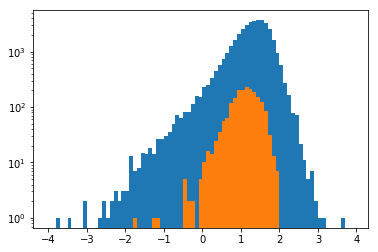

In [150]:
z = joined_lofar_help['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad = (joined_lofar_help['Total_flux']*1E-26/(1+z)**(-0.7))*(4*np.pi*dist**2)
dust_lum = (joined_lofar_help['cigale_dustlumin'])
q = np.log10(dust_lum/3.75E12) - np.log10(lum_rad)
plt.hist(q,log=True,bins=np.arange(-4,4,0.1))
print(np.median(q))
print(np.mean(q))
print(np.std(q)/np.sqrt(len(q)))
print('--------')

z = multi_match['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad = (multi_match['Total_flux']*1E-26/(1+z)**(-0.7))*(4*np.pi*dist**2)
dust_lum = (multi_match['cigale_dustlumin'])
q = np.log10(dust_lum/3.75E12) - np.log10(lum_rad)
plt.hist(q,log=True,bins=np.arange(-4,4,0.1))
print(np.median(q))
print(np.mean(q))
print(np.std(q)/np.sqrt(len(q)))
plt.show()

contours are at [-6.06830908e-05  3.59053734e-07  6.14011983e-05  1.22443343e-04
  1.83485487e-04]
plotting 1 sources
plotting 1 sources
plotting 3 sources


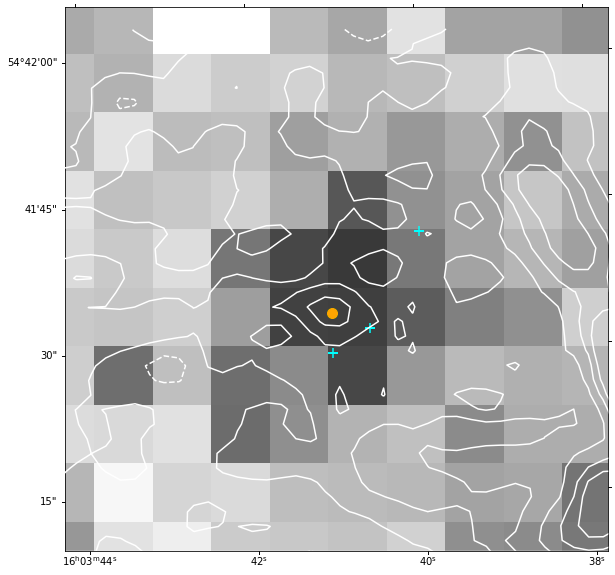

contours are at [-5.31534875e-05  1.73476127e-06  5.66230100e-05  1.11511259e-04
  1.66399507e-04]
plotting 1 sources
plotting 1 sources
plotting 3 sources


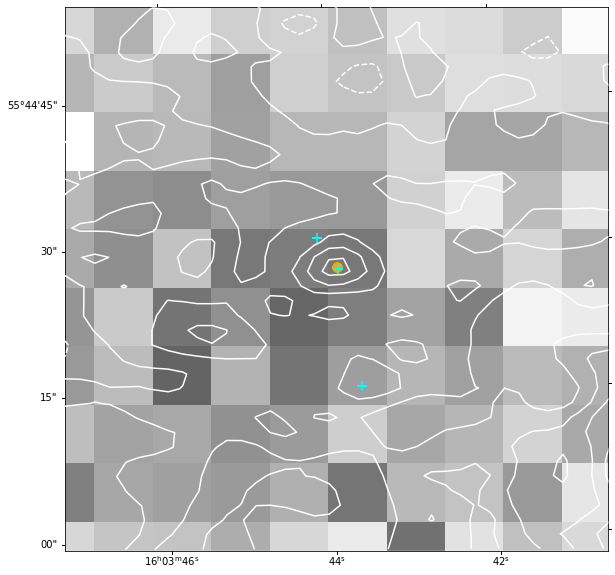

contours are at [-5.31217086e-05 -6.63022066e-07  5.17956644e-05  1.04254351e-04
  1.56713037e-04]
plotting 2 sources
plotting 2 sources
plotting 3 sources


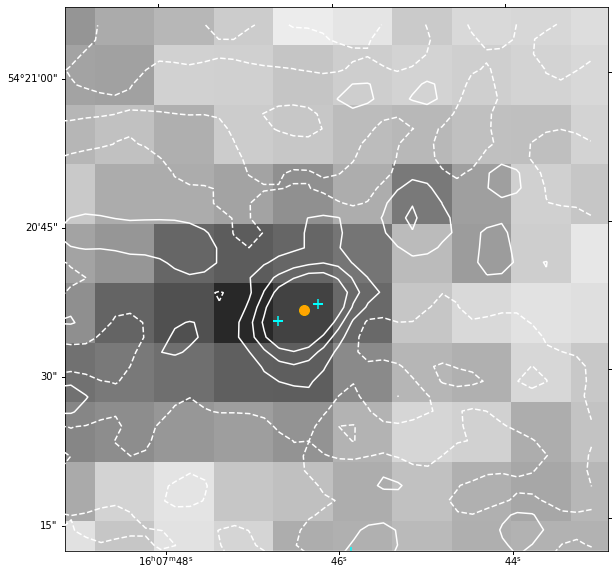

contours are at [-4.56059478e-05 -6.48469021e-08  4.54762540e-05  9.10173549e-05
  1.36558456e-04]
plotting 5 sources
plotting 5 sources
plotting 5 sources


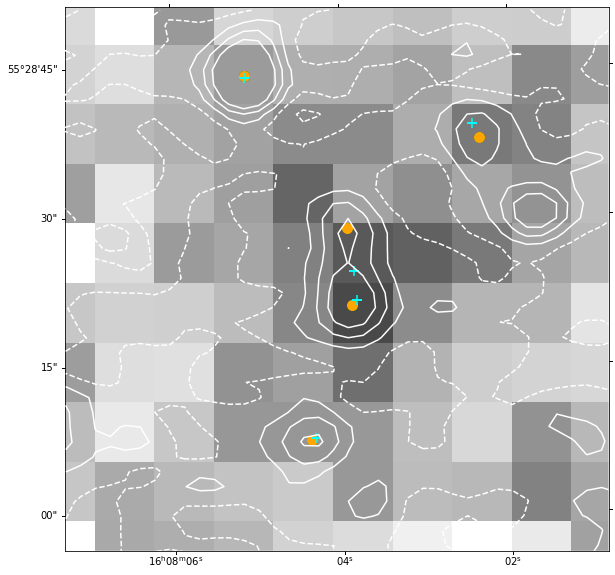

contours are at [-5.51757931e-05 -5.39828148e-07  5.40961368e-05  1.08732102e-04
  1.63368067e-04]
plotting 4 sources
plotting 4 sources
plotting 4 sources


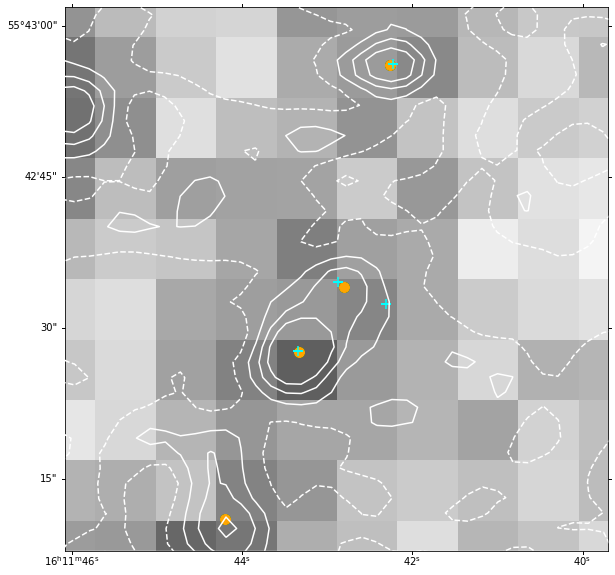

contours are at [-5.62914121e-05  2.49227444e-06  6.12759610e-05  1.20059648e-04
  1.78843334e-04]
plotting 3 sources
plotting 3 sources
plotting 3 sources


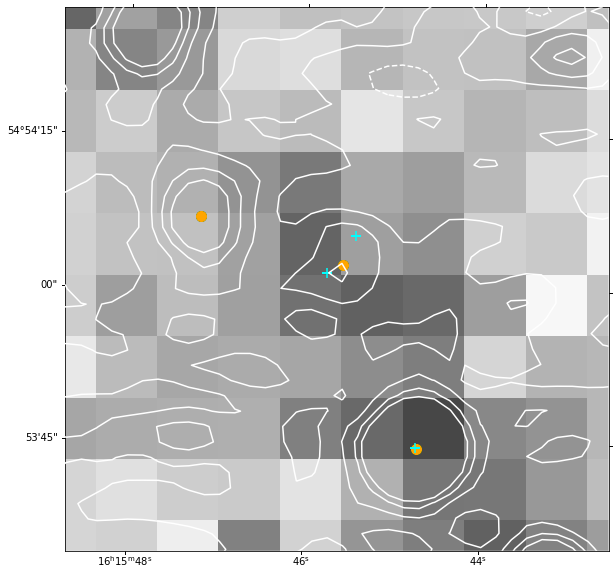

contours are at [-4.89800125e-05 -4.47498073e-06  4.00300511e-05  8.45350828e-05
  1.29040115e-04]
plotting 3 sources
plotting 3 sources
plotting 3 sources


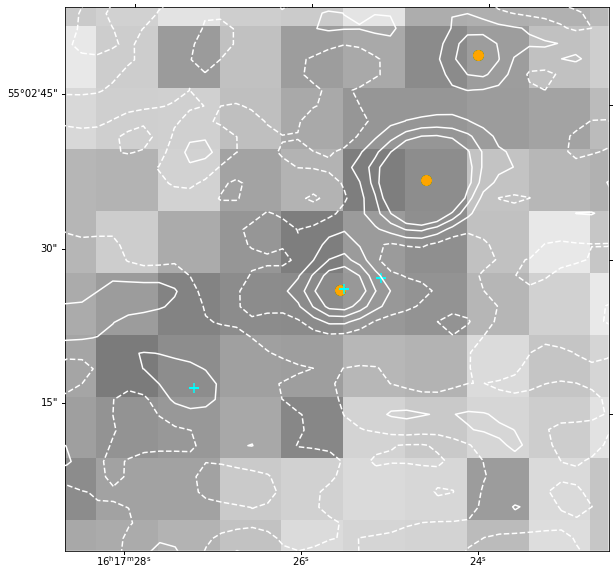

In [153]:
z = multi_match['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad = (multi_match['Total_flux']*1E-26/(1+z)**(-0.7))*(4*np.pi*dist**2)
dust_lum = (multi_match['cigale_dustlumin'])
q = np.log10(dust_lum/3.75E12) - np.log10(lum_rad)
mask = q>1.9
ras = multi_match['RA'][mask]
decs = multi_match['DEC'][mask]

plot_params = {'marker':['o','o','+','v','X','d'],
              'col':['green','orange','cyan'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

for n in range(len(ras)):

    image_plotting.plot_figure(im250,[lofar_data,lofar_sources,help_ldust],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

contours are at [-2.15448977e-04  3.79117992e-05  2.91272576e-04  5.44633352e-04
  7.97994129e-04]
plotting 2 sources
plotting 1 sources
plotting 4 sources


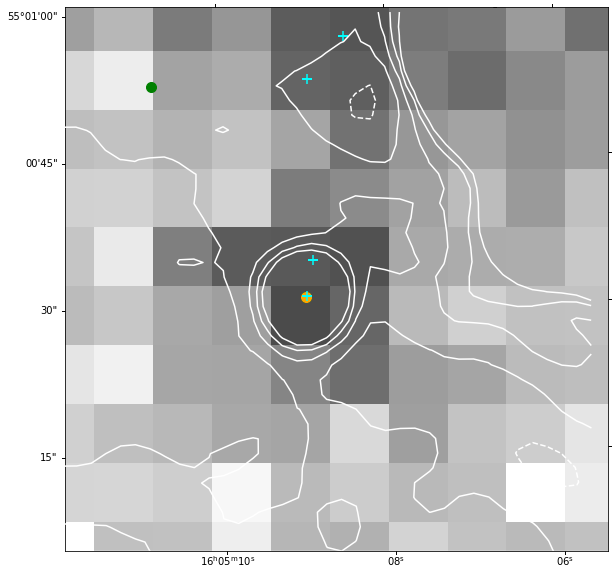

contours are at [-2.15448977e-04  3.79117992e-05  2.91272576e-04  5.44633352e-04
  7.97994129e-04]
plotting 2 sources
plotting 1 sources
plotting 4 sources


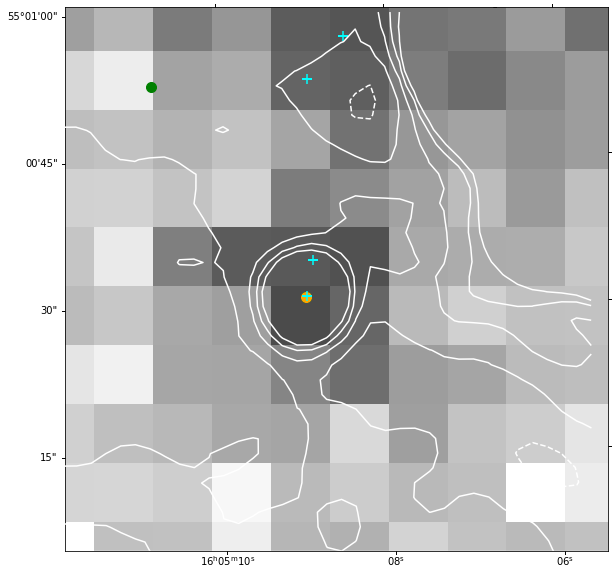

contours are at [-6.79773906e-05 -1.06499756e-05  4.66774395e-05  1.04004855e-04
  1.61332270e-04]
plotting 2 sources
plotting 2 sources
plotting 2 sources


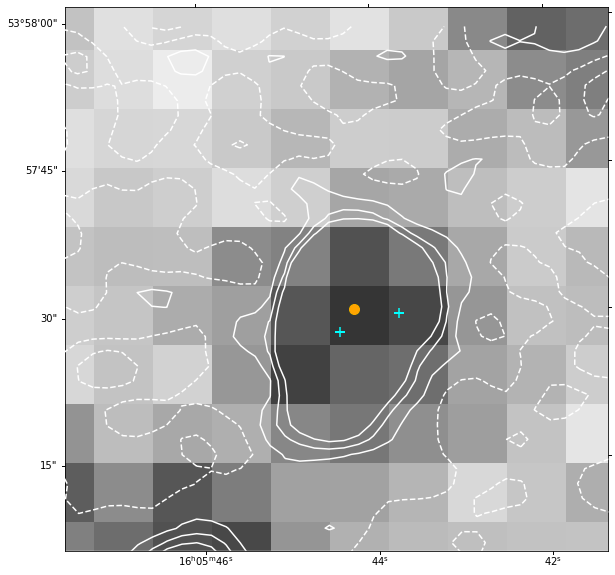

contours are at [-6.82260118e-05 -3.67513778e-06  6.08757362e-05  1.25426610e-04
  1.89977484e-04]
plotting 1 sources
plotting 1 sources
plotting 2 sources


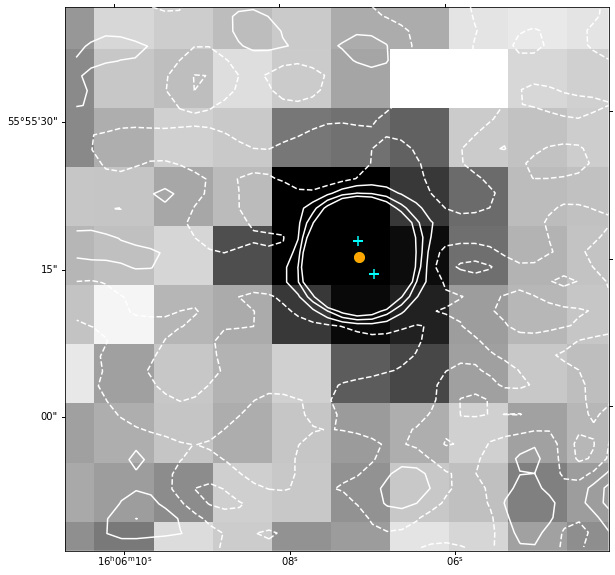

contours are at [-1.61961352e-04 -6.90253185e-06  1.48156289e-04  3.03215109e-04
  4.58273930e-04]
plotting 1 sources
plotting 1 sources
plotting 3 sources


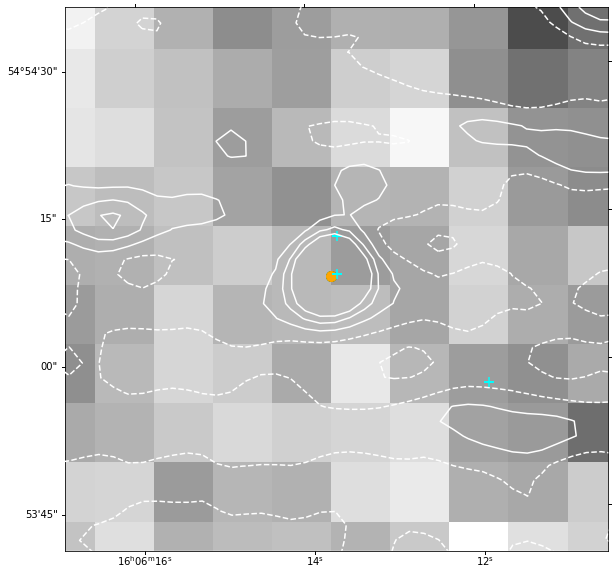

contours are at [-1.08303898e-04 -2.01372502e-05  6.80293976e-05  1.56196045e-04
  2.44362693e-04]
plotting 1 sources
plotting 1 sources
plotting 3 sources


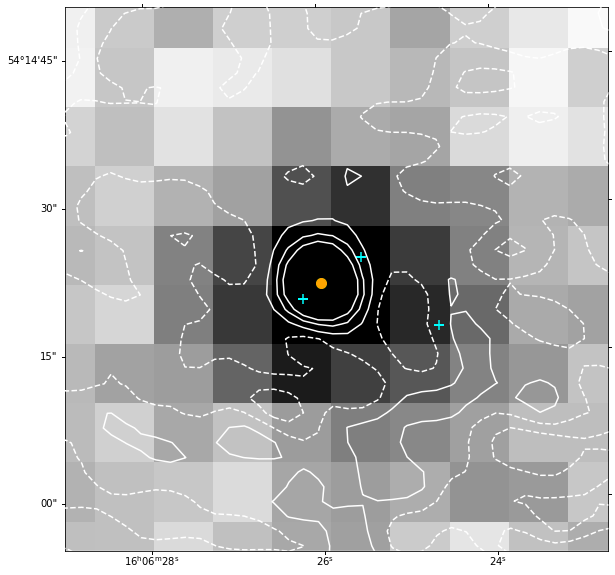

contours are at [-4.59889865e-05 -7.22767699e-06  3.15336325e-05  7.02949420e-05
  1.09056251e-04]
plotting 2 sources
plotting 2 sources
plotting 4 sources


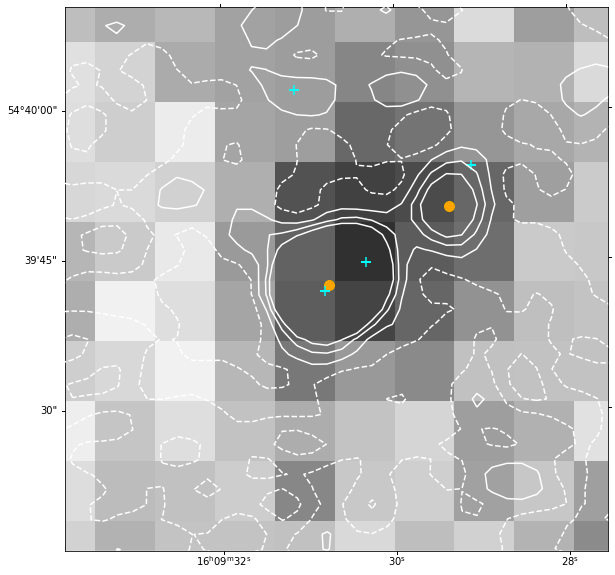

contours are at [-3.81032348e-05 -2.11789002e-07  3.76796568e-05  7.55711027e-05
  1.13462549e-04]
plotting 2 sources
plotting 2 sources
plotting 4 sources


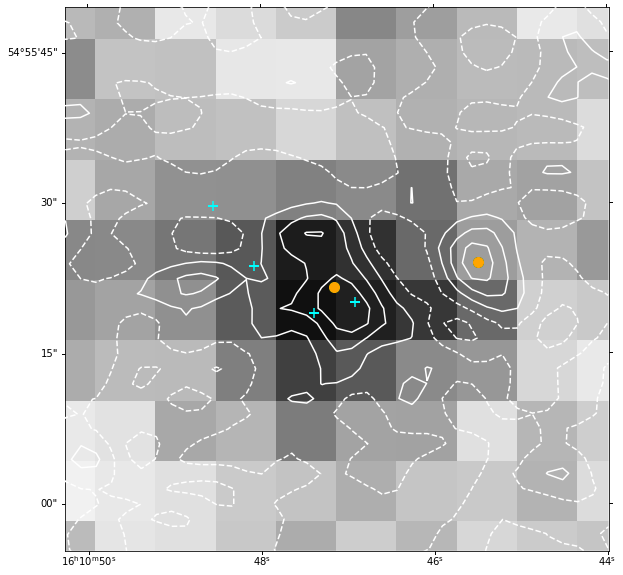

contours are at [-4.84205829e-05 -7.34296417e-06  3.37346545e-05  7.48122732e-05
  1.15889892e-04]
plotting 2 sources
plotting 2 sources
plotting 2 sources


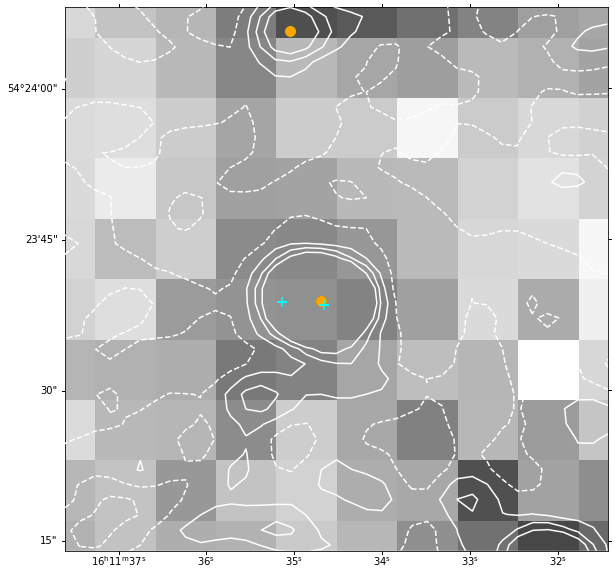

contours are at [-6.43150858e-05 -1.89325257e-06  6.05285807e-05  1.22950414e-04
  1.85372247e-04]
plotting 1 sources
plotting 0 sources
plotting 2 sources


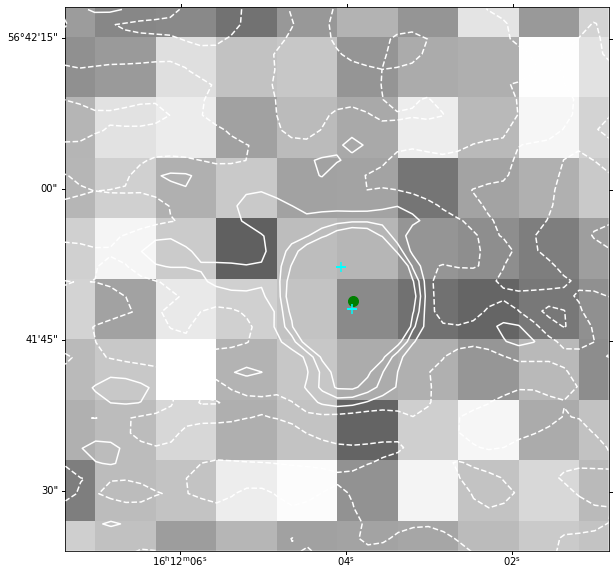

contours are at [-4.40332435e-05  1.29058262e-06  4.66144087e-05  9.19382348e-05
  1.37262061e-04]
plotting 1 sources
plotting 1 sources
plotting 3 sources


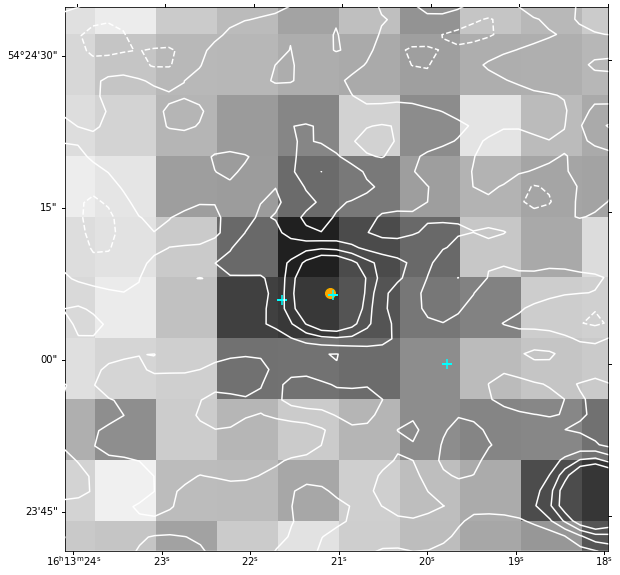

contours are at [-1.36079228e-04  3.63596394e-05  2.08798507e-04  3.81237375e-04
  5.53676243e-04]
plotting 1 sources
plotting 1 sources
plotting 3 sources


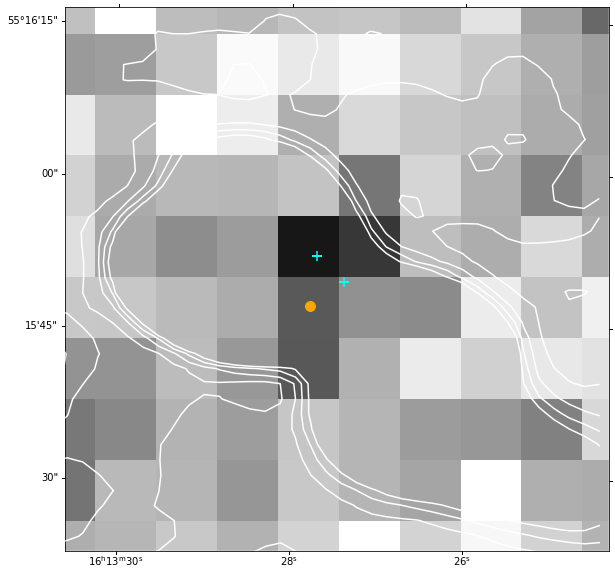

contours are at [-1.36079228e-04  3.63596394e-05  2.08798507e-04  3.81237375e-04
  5.53676243e-04]
plotting 1 sources
plotting 1 sources
plotting 3 sources


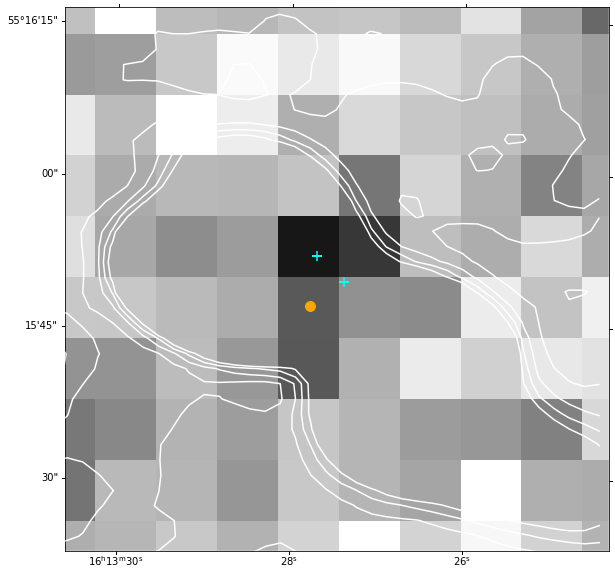

contours are at [-5.09457920e-05 -2.66564514e-06  4.56145017e-05  9.38946485e-05
  1.42174795e-04]
plotting 1 sources
plotting 1 sources
plotting 2 sources


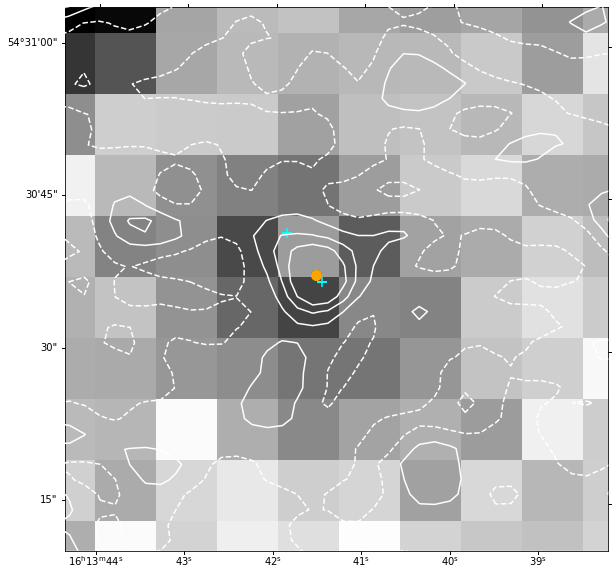

contours are at [-5.81949195e-05 -9.39302631e-06  3.94088669e-05  8.82107601e-05
  1.37012653e-04]
plotting 1 sources
plotting 1 sources
plotting 3 sources


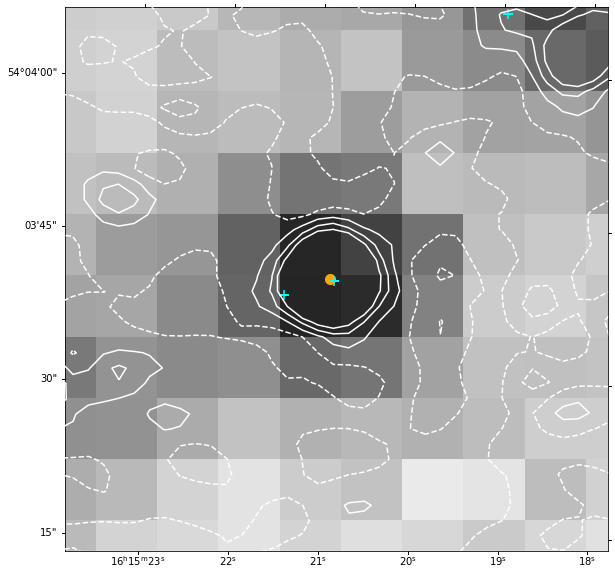

contours are at [-7.53112762e-05 -1.20273475e-05  5.12565811e-05  1.14540510e-04
  1.77824438e-04]
plotting 3 sources
plotting 0 sources
plotting 3 sources


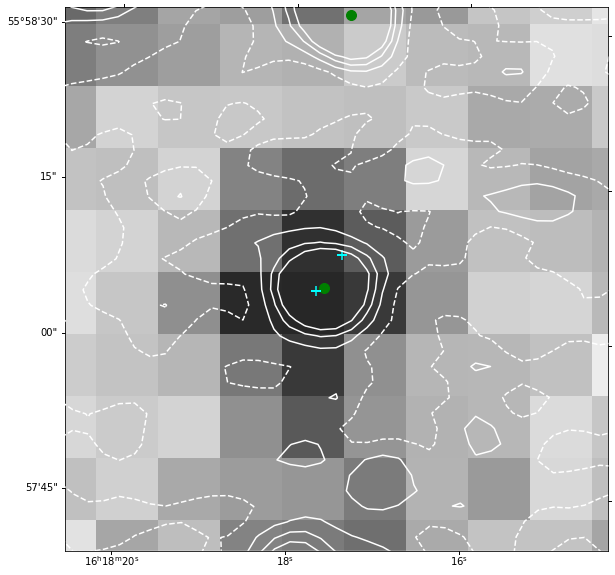

contours are at [-1.00543871e-04  3.57192912e-06  1.07687729e-04  2.11803529e-04
  3.15919329e-04]
plotting 1 sources
plotting 0 sources
plotting 2 sources


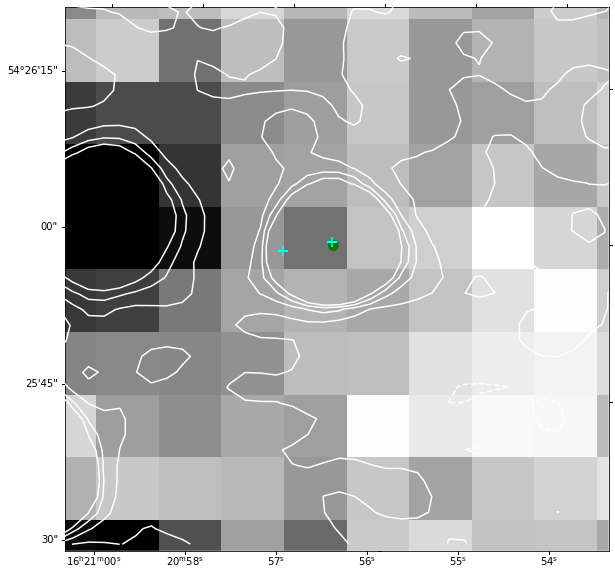

In [155]:
z = multi_match['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad = (multi_match['Total_flux']*1E-26/(1+z)**(-0.7))*(4*np.pi*dist**2)
dust_lum = (multi_match['cigale_dustlumin'])
q = np.log10(dust_lum/3.75E12) - np.log10(lum_rad)
mask = q<0
ras = multi_match['RA'][mask]
decs = multi_match['DEC'][mask]

plot_params = {'marker':['o','o','+','v','X','d'],
              'col':['green','orange','cyan'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

for n in range(len(ras)):

    image_plotting.plot_figure(im250,[lofar_data,lofar_sources,help_ldust],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

In [167]:
cols = ['Total_flux','cigale_dustlumin','redshift']
tmp = multi_match[:2][cols]

z = tmp['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad = (tmp['Total_flux']*1E-26/(1+z)**(-0.7))*(4*np.pi*dist**2)
dust_lum = (np.sum(tmp['cigale_dustlumin']))
q = np.log10(dust_lum/3.75E12) - np.log10(lum_rad)
q

In [168]:
q

1.583034879799495
1.6263224432172905


In [170]:
cols = ['Total_flux','cigale_dustlumin','redshift']
tmp = multi_match[2:4][cols]
z = tmp['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad = (tmp['Total_flux']*1E-26/(1+z)**(-0.7))*(4*np.pi*dist**2)
dust_lum = (np.sum(tmp['cigale_dustlumin']))
q = np.log10(dust_lum/3.75E12) - np.log10(lum_rad)
q

1.4595235397051844
1.101555112857163


In [171]:
tmp

Total_flux,cigale_dustlumin,redshift
float64,float64,float64
0.0014583905325278013,3.1271598684607437e+38,0.6468
0.0014583905325278013,9.979294477428935e+37,0.8716


In [173]:
multi_match[6:8][cols]

Total_flux,cigale_dustlumin,redshift
float64,float64,float64
0.0003711689537649886,8.2538086915156485e+37,0.4852
0.0003711689537649886,1.3965293800356694e+38,0.9676
